In [3]:
%matplotlib inline
import os
import tqdm
import os.path as osp
import pandas as pd
import numpy as np
import itertools
import glob
import json 
import plotnine as pn
import matplotlib.pyplot as plt
import collections
from tcre.env import *
from tcre.supervision import get_candidate_classes, SPLIT_DEV, SPLIT_VAL, SPLIT_TEST, SPLIT_MAP
from tcre.exec.v1 import optim
from tcre.modeling import features
from snorkel import SnorkelSession
from snorkel.models import Candidate
import logging
session = SnorkelSession()
%run ../src/tcre/logging.py
classes = get_candidate_classes()

/opt/conda/envs/nlp/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [4]:
#output_dir = osp.join(RESULTS_DATA_DIR, 'gridsearch-dev', 'run1')
output_dir = osp.join(RESULTS_DATA_DIR, 'gridsearch-dev', 'run2')
output_dir

'/lab/data/results/gridsearch-dev/run2'

In [5]:
tasks = [classes[c].field for c in classes]
tasks

['inducing_cytokine', 'secreted_cytokine', 'inducing_transcription_factor']

### Initialize Optimizers

In [46]:
from skopt.space import Categorical
from skopt.space import Space

space = Space([
    Categorical(['doub_01'], name='marker_list'),
    Categorical([True, False], name='use_secondary'),
    Categorical([True, False], name='use_swaps'),
    Categorical([True], name='use_positions'),
    Categorical(['w2v_frozen', 'w2v_trained'], name='wrd_embedding_type'),
    Categorical(['XL', 'XXL', 'XXXL', 'XXXXL'], name='model_size'),
    Categorical([0.0, .00001, .0001, .001], name='weight_decay'),
    Categorical([.005, .01, .05], name='learning_rate'),
    Categorical([0.0, 0.25, 0.5, 0.75], name='dropout'),
    Categorical(['LSTM'], name='cell_type'),
    Categorical([False], name='bidirectional')
])

In [47]:
n_space = np.prod([len(dim.categories) for dim in space])
print('Number of combinations in parameter space:', n_space)

Number of combinations in parameter space: 1536


In [8]:
space.rvs()[0]

['doub_01',
 False,
 True,
 True,
 'w2v_frozen',
 'XXXL',
 0.0,
 0.01,
 0.75,
 'LSTM',
 False]

In [9]:
import imp
imp.reload(optim)

<module 'tcre.exec.v1.optim' from '/lab/repos/t-cell-relation-extraction/src/tcre/exec/v1/optim.py'>

In [10]:
from skopt import forest_minimize, dummy_minimize

#optimizers = {task: optim.TaskParameterOptimizer(task, space, output_dir, minimizer=forest_minimize) for task in tasks}
optimizers = {task: optim.TaskParameterOptimizer(task, space, output_dir, minimizer=dummy_minimize) for task in tasks}

In [11]:
optimizers[tasks[0]].client.exceptions

['log_level',
 'seed',
 'vocab_limit',
 'use_lower',
 'save_keys',
 'log_iter_interval',
 'log_epoch_interval',
 'balance',
 'batch_size',
 'simulation_strategy',
 'swap_list']

### Create Splits for Tasks

In [12]:
cands = session.query(Candidate).filter(Candidate.split.in_([SPLIT_DEV, SPLIT_VAL, SPLIT_TEST])).all()
len(cands)

2368

In [13]:
c = cands[0]

In [14]:
c.gold_labels[0].value

1

In [15]:
# Train on dev, use val for validation, and make test predictions
TARGET_MAP = {'dev': 'train', 'val': 'val', 'test': 'test'}
df_cand = pd.DataFrame([
    dict(id=c.id, type=c.type, split=TARGET_MAP[SPLIT_MAP[c.split]], label=c.gold_labels[0].value if c.gold_labels else 0)
    for c in cands
])
df_cand.head()

,id,label,split,type
0,30167,1,train,inducing_cytokine
1,30168,0,train,inducing_cytokine
2,30169,1,train,inducing_cytokine
3,30170,1,train,inducing_cytokine
4,30171,0,train,inducing_cytokine


In [16]:
df_cand.groupby(['type', 'split']).size().unstack()

split,test,train,val
type,,,
inducing_cytokine,100,673,97
inducing_transcription_factor,100,410,117
secreted_cytokine,100,673,98


In [17]:
df_cand.groupby(['type', 'split'])['label'].value_counts().unstack().fillna(0).astype(int)

label                                -1    0    1
type                          split              
inducing_cytokine             test   86    0   14
                              train   0  540  133
                              val    84    0   13
inducing_transcription_factor test   82    0   18
                              train   0  324   86
                              val    95    0   22
secreted_cytokine             test   80    0   20
                              train   0  592   81
                              val    79    0   19

In [18]:
for task in tasks:
    dft = df_cand.set_index('type').loc[task]
    splits = dft.groupby('split')['id'].unique().apply(list)
    splits_file = optimizers[task].write_splits(splits)
    print(f'Splits written to {splits_file}')

Splits written to /lab/data/results/gridsearch-dev/run2/inducing_cytokine/splits/hopt_inducing_cytokine.json
Splits written to /lab/data/results/gridsearch-dev/run2/secreted_cytokine/splits/hopt_secreted_cytokine.json
Splits written to /lab/data/results/gridsearch-dev/run2/inducing_transcription_factor/splits/hopt_inducing_transcription_factor.json


### Run Search

In [19]:
# Show an example command to be run 
print(optimizers[tasks[0]].get_cmd(space.rvs()[0]))

python /lab/repos/t-cell-relation-extraction/src/tcre/exec/v1/cli.py --relation-class=inducing_cytokine --device="cuda:1" --output-dir=/lab/data/results/gridsearch-dev/run2/inducing_cytokine/data train --splits-file=/lab/data/results/gridsearch-dev/run2/inducing_cytokine/splits/hopt_inducing_cytokine.json --use-checkpoints=False --save-keys="history" --marker-list=doub_01 --use-secondary=True --use-swaps=False --use-positions=True --wrd-embedding-type=w2v_frozen --model-size=XXXL --weight-decay=0.0001 --learning-rate=0.005 --dropout=0.75 --cell-type=LSTM --bidirectional=False > /lab/data/results/gridsearch-dev/run2/inducing_cytokine/log/log.txt 2>&1


In [20]:
# For 3 tasks at about about 30s per iteration, show common time estimations:
time_per_iter_sec = 30
n_iter = np.array([10, 100, 250, 500, 1000])
for n in n_iter:
    time = n * time_per_iter_sec * len(tasks) / 3600
    print(f'Iterations = {n} --> Time = {time} (hrs)')

Iterations = 10 --> Time = 0.25 (hrs)
Iterations = 100 --> Time = 2.5 (hrs)
Iterations = 250 --> Time = 6.25 (hrs)
Iterations = 500 --> Time = 12.5 (hrs)
Iterations = 1000 --> Time = 25.0 (hrs)


In [22]:
results = {}

for task in tasks:
    optimizer = optimizers[task]
    logging.info(f'Running optimization for task {task}')
    # kappa=3.090 -> 99.8% confidence interval (favors exploration when higher than default 1.96)
    #res, scores, callbacks = optimizer.run(n_iterations=250, progress_interval=1, checkpoint_interval=10, n_random_starts=10, acq_func='LCB', kappa=3.090)
    res, scores, callbacks = optimizer.run(n_iterations=30, progress_interval=1, checkpoint_interval=10)
    
    # Save scores for non-objective (i.e. validation) after converting to long form
    scores = pd.DataFrame(scores)
    scores.columns = pd.MultiIndex.from_tuples([c for c in scores])
    scores = scores.rename_axis('iteration', axis=0).rename_axis(('metric', 'type'), axis=1)
    scores = scores.stack().stack().rename('value').reset_index()
    scores_file = osp.join(optimizer.output_dir, 'scores.feather')
    scores.to_feather(scores_file)
    logging.info(f'Saved scores to {scores_file}')
    
    # Checkpoint final result since it is not saved at every step
    callbacks['saver'].i = -1
    callbacks['saver'](res)
    logging.info(f'Saved final result')
    
    results[task] = res, scores, callbacks

2019-07-09 16:48:49,618:INFO:root: Running optimization for task inducing_cytokine
2019-07-09 16:48:49,620:INFO:tcre.exec.v1.optim: Beginning parameter search with max iterations 30
2019-07-09 16:49:15,007:INFO:tcre.exec.v1.optim: Completed iteration 1 of 30 (score = -0.36363636363636304)
2019-07-09 16:49:39,959:INFO:tcre.exec.v1.optim: Completed iteration 2 of 30 (score = -0.44444444444444403)
2019-07-09 16:50:11,763:INFO:tcre.exec.v1.optim: Completed iteration 3 of 30 (score = -0.4)
2019-07-09 16:50:34,133:INFO:tcre.exec.v1.optim: Completed iteration 4 of 30 (score = -0.24000000000000002)
2019-07-09 16:51:04,614:INFO:tcre.exec.v1.optim: Completed iteration 5 of 30 (score = -0.344827586206896)
2019-07-09 16:51:29,347:INFO:tcre.exec.v1.optim: Completed iteration 6 of 30 (score = -0.4375)
2019-07-09 16:51:54,379:INFO:tcre.exec.v1.optim: Completed iteration 7 of 30 (score = -0.416666666666666)
2019-07-09 16:52:19,015:INFO:tcre.exec.v1.optim: Completed iteration 8 of 30 (score = -0.461538

In [23]:
print(tasks[0])
res, scores, callbacks = results[tasks[0]]

inducing_cytokine


In [24]:
times = callbacks['timer'].iter_time
pd.Series(times).describe()

count    30.000000
mean     26.304564
std       3.069430
min      21.674597
25%      24.641933
50%      26.362815
75%      27.770711
max      34.055811
dtype: float64

In [25]:
res.func_vals[:5]

array([-0.36363636, -0.44444444, -0.4       , -0.24      , -0.34482759])

In [26]:
pd.DataFrame(res.x_iters[:5], columns=[dim.name for dim in space])

,marker_list,use_secondary,use_swaps,use_positions,wrd_embedding_type,model_size,weight_decay,learning_rate,dropout,cell_type,bidirectional
0,doub_01,True,False,True,w2v_frozen,XXL,0.000,0.005,0.75,LSTM,False
1,doub_01,False,False,True,w2v_frozen,XXL,0.001,0.010,0.25,LSTM,False
2,doub_01,False,False,True,w2v_frozen,XXXL,0.001,0.005,0.00,LSTM,False
3,doub_01,False,False,True,w2v_frozen,L,0.001,0.001,0.75,LSTM,False
4,doub_01,True,True,True,w2v_frozen,XXXL,0.001,0.001,0.00,LSTM,False


In [27]:
res.models[:5]

[]

## Analysis

In [28]:
output_dir

'/lab/data/results/gridsearch-dev/run2'

In [29]:
!ls $output_dir

inducing_cytokine  inducing_transcription_factor  secreted_cytokine


In [30]:
import skopt
# Restore from serialized data

results = {}
for task in tasks:
    optimizer = optimizers[task]
    res = skopt.load(optimizer.get_checkpoints_file())
    
    scores = None
    scores_file = osp.join(optimizer.output_dir, 'scores.feather')
    if osp.exists(scores_file):
        scores = pd.read_feather(scores_file)
    
    results[task] = res, scores, globals().get('times') 

In [31]:
def get_dfx(results):
    df = []
    for k in results:
        res = results[k][0]
        dfx = pd.DataFrame(res.x_iters, columns=[dim.name for dim in space])
        dfx['score'] = -res.func_vals
        dfx['task'] = k
        dfx['iteration'] = np.arange(len(dfx))
        df.append(dfx)
    return pd.concat(df)

In [32]:
dfx = get_dfx(results)
props = dfx.drop(['score', 'task', 'iteration'], axis=1).columns.tolist()
print(props)
dfx.head()

['marker_list', 'use_secondary', 'use_swaps', 'use_positions', 'wrd_embedding_type', 'model_size', 'weight_decay', 'learning_rate', 'dropout', 'cell_type', 'bidirectional']


,marker_list,use_secondary,use_swaps,use_positions,wrd_embedding_type,model_size,weight_decay,learning_rate,dropout,cell_type,bidirectional,score,task,iteration
0,doub_01,True,False,True,w2v_frozen,XXL,0.000,0.005,0.75,LSTM,False,0.363636,inducing_cytokine,0
1,doub_01,False,False,True,w2v_frozen,XXL,0.001,0.010,0.25,LSTM,False,0.444444,inducing_cytokine,1
2,doub_01,False,False,True,w2v_frozen,XXXL,0.001,0.005,0.00,LSTM,False,0.400000,inducing_cytokine,2
3,doub_01,False,False,True,w2v_frozen,L,0.001,0.001,0.75,LSTM,False,0.240000,inducing_cytokine,3
4,doub_01,True,True,True,w2v_frozen,XXXL,0.001,0.001,0.00,LSTM,False,0.344828,inducing_cytokine,4


In [33]:
# Show top configs by task
dfx.groupby('task').apply(lambda g: g.sort_values('score').iloc[-8:])

marker_list  use_secondary  use_swaps  \
task                                                                     
inducing_cytokine             10     doub_01          False       True   
                              6      doub_01          False      False   
                              5      doub_01          False      False   
                              1      doub_01          False      False   
                              15     doub_01           True       True   
                              8      doub_01          False       True   
                              7      doub_01          False      False   
                              27     doub_01          False      False   
inducing_transcription_factor 9      doub_01           True       True   
                              23     doub_01           True      False   
                              18     doub_01           True       True   
                              15     doub_01           True       True   
                              25     doub_01           True       True   
                              12     doub_01           True       True   
                              13     doub_01           True      False   
                              4      doub_01           True       True   
secreted_cytokine             2      doub_01          False      False   
                              18     doub_01           True       True   
                              10     doub_01          False       True   
                              1      doub_01          False      False   
                              12     doub_01           True       True   
                              15     doub_01           True       True   
                              24     doub_01           True       True   
                              5      doub_01          False      False   

                                  use_positions wrd_embedding_type model_size  \
task                                                                            
inducing_cytokine             10           True         w2v_frozen        XXL   
                              6            True         w2v_frozen        XXL   
                              5            True         w2v_frozen          L   
                              1            True         w2v_frozen        XXL   
                              15           True         w2v_frozen       XXXL   
                              8            True         w2v_frozen        XXL   
                              7            True         w2v_frozen       XXXL   
                              27           True         w2v_frozen        XXL   
inducing_transcription_factor 9            True         w2v_frozen       XXXL   
                              23           True         w2v_frozen         XL   
                              18           True         w2v_frozen          L   
                              15           True         w2v_frozen       XXXL   
                              25           True         w2v_frozen       XXXL   
                              12           True         w2v_frozen         XL   
                              13           True         w2v_frozen         XL   
                              4            True         w2v_frozen       XXXL   
secreted_cytokine             2            True         w2v_frozen       XXXL   
                              18           True         w2v_frozen          L   
                              10           True         w2v_frozen        XXL   
                              1            True         w2v_frozen        XXL   
                              12           True         w2v_frozen         XL   
                              15           True         w2v_frozen       XXXL   
                              24           True         w2v_frozen         XL   
                              5            True         w2v_frozen          L   

 

### Parameter Regression

In [34]:
from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning, message='The default of the `iid` parameter.*')

def get_coefs(est):
    coefs = []
    grps = dfx.groupby(['task'])
    fig, axs = plt.subplots(1, len(grps))
    if len(grps) == 1:
        axs = [axs]
    fig.set_size_inches(18, 4)
    for i, (k, g) in enumerate(grps):
        X = pd.get_dummies(g.drop(['task', 'iteration', 'score'], axis=1).astype(str), prefix_sep=':')
        y = g['score'].values
        est = est.fit(X.values, y)
        y_pred = est.predict(X)
        score = max(r2_score(y, y_pred), 0)
        title = f'{est.__class__.__name__} {k} (R2={score:.2f})'
        pd.DataFrame({'y_true': y, 'y_pred': y_pred}).plot(kind='scatter', x='y_pred', y='y_true', ax=axs[i], title=title)
        coefs.append(
            pd.Series(est.coef_, index=X.columns.to_list()).sort_index()
            .append(pd.Series(dict(task=k, score=score, est=est.__class__.__name__)))
        )
    return est, pd.DataFrame(coefs)

def plot_coefs(est, coefs):
    return (
        pn.ggplot(
            coefs
                .set_index('task').rename_axis('metric', axis='columns').stack().rename('value').reset_index()
                .assign(metric=lambda df: pd.Categorical(df['metric'], ordered=True, categories=df.groupby('metric')['value'].mean().sort_values().index)), 
            pn.aes(x='metric', y='value', fill='task', color='task', group='task')
        ) + 
        pn.geom_point() +
        pn.geom_line() + 
        pn.ggtitle(type(est).__name__) + 
        pn.theme(figure_size=(12, 4), axis_text_x=pn.element_text(rotation=90, hjust=.5))
    )

In [35]:
from sklearn.linear_model import LassoCV, RidgeCV, ElasticNetCV

bidirectional:False  \
task                          score    est          weight                          
inducing_cytokine             0.618068 RidgeCV      0.306541                  0.0   
                              0.704890 LassoCV      0.349602                  0.0   
                              0.693304 ElasticNetCV 0.343856                  0.0   
inducing_transcription_factor 0.562497 RidgeCV      0.315008                  0.0   
                              0.613428 LassoCV      0.343530                  0.0   

                                                              cell_type:LSTM  \
task                          score    est          weight                     
inducing_cytokine             0.618068 RidgeCV      0.306541             0.0   
                              0.704890 LassoCV      0.349602             0.0   
                              0.693304 ElasticNetCV 0.343856             0.0   
inducing_transcription_factor 0.562497 RidgeCV      0.315008             0.0   
                              0.613428 LassoCV      0.343530             0.0   

                                                              dropout:0.0  \
task                          score    est          weight                  
inducing_cytokine             0.618068 RidgeCV      0.306541     0.031066   
                              0.704890 LassoCV      0.349602     0.002580   
                              0.693304 ElasticNetCV 0.343856     0.008543   
inducing_transcription_factor 0.562497 RidgeCV      0.315008     0.014331   
                              0.613428 LassoCV      0.343530     0.000000   

                                                              dropout:0.25  \
task                          score    est          weight                   
inducing_cytokine             0.618068 RidgeCV      0.306541     -0.023913   
                              0.704890 LassoCV      0.349602     -0.017128   
                              0.693304 ElasticNetCV 0.343856     -0.017282   
inducing_transcription_factor 0.562497 RidgeCV      0.315008     -0.022689   
                              0.613428 LassoCV      0.343530     -0.008850   

                                                              dropout:0.5  \
task                          score    est          weight                  
inducing_cytokine             0.618068 RidgeCV      0.306541     0.006178   
                              0.704890 LassoCV      0.349602     0.000000   
                              0.693304 ElasticNetCV 0.343856     0.000000   
inducing_transcription_factor 0.562497 RidgeCV      0.315008     0.018848   
                              0.613428 LassoCV      0.343530     0.029554   

                                                              dropout:0.75  \
task                          score    est          weight                   
inducing_cytokine             0.618068 RidgeCV      0.306541     -0.011679   
                              0.704890 LassoCV      0.349602     -0.000000   
                              0.693304 ElasticNetCV 0.343856     -0.000000   
inducing_transcription_factor 0.562497 RidgeCV      0.315008     -0.010132   
                              0.613428 LassoCV      0.343530     -0.000000   

                                                              learning_rate:0.001  \
task                          score    est          weight                          
inducing_cytokine             0.618068 RidgeCV      0.306541            -0.043160   
                              0.704890 LassoCV      0.349602            -0.087404   
                              0.693304 ElasticNetCV 0.343856            -0.079436   
inducing_transcription_factor 0.562497 RidgeCV      0.315008            -0.041107   
                              0.613428 LassoCV      0.343530            -0.097871   

                                                              learning_rate:0.005  \
task                          score    est        

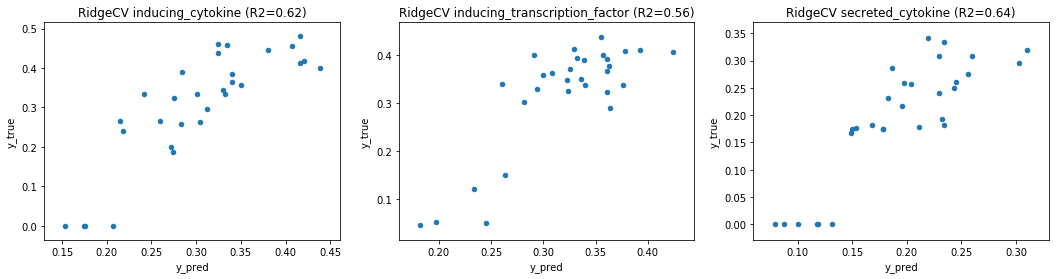

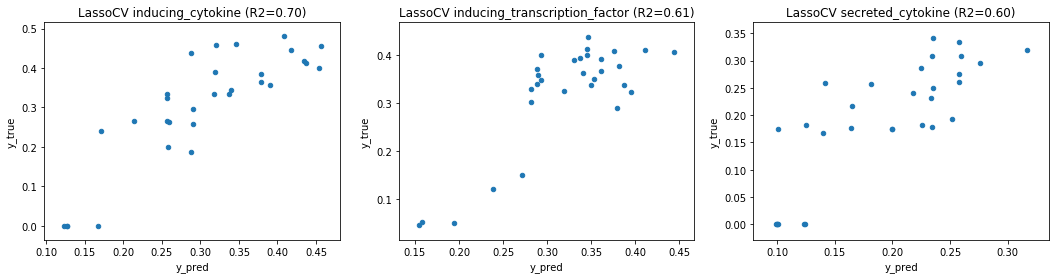

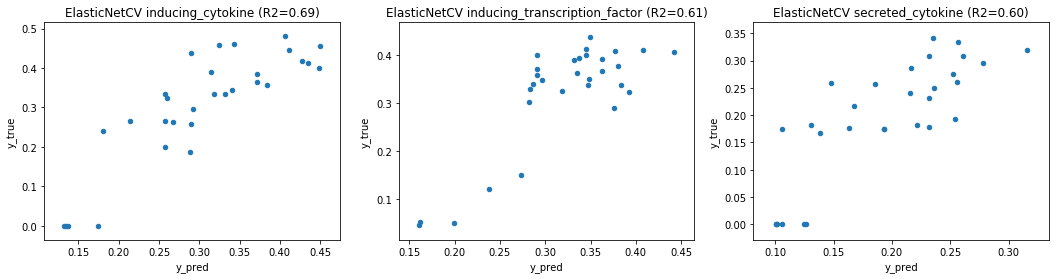

In [36]:
df_coef = pd.concat([
    get_coefs(RidgeCV(normalize=True, cv=5))[1],
    get_coefs(LassoCV(normalize=True, cv=5, random_state=1))[1],
    get_coefs(ElasticNetCV(normalize=True, cv=5, random_state=1))[1]
])

# Add weight for each model as R2 for model / R2 for all models
df_coef = df_coef.groupby('task', group_keys=False).apply(lambda g: g.assign(weight=(g['score'] / g['score'].sum())))
df_coef = df_coef.set_index(['task', 'score', 'est', 'weight'])

df_coef.head()

In [37]:
df_coef_lng = df_coef.rename_axis('parameter', axis='columns').stack().rename('value').reset_index()
df_coef_lng['weighted_value'] = df_coef_lng['value'] * df_coef_lng['weight']
df_coef_lng.head()

,task,score,est,weight,parameter,value,weighted_value
0,inducing_cytokine,0.618068,RidgeCV,0.306541,bidirectional:False,0.000000,0.000000
1,inducing_cytokine,0.618068,RidgeCV,0.306541,cell_type:LSTM,0.000000,0.000000
2,inducing_cytokine,0.618068,RidgeCV,0.306541,dropout:0.0,0.031066,0.009523
3,inducing_cytokine,0.618068,RidgeCV,0.306541,dropout:0.25,-0.023913,-0.007330
4,inducing_cytokine,0.618068,RidgeCV,0.306541,dropout:0.5,0.006178,0.001894


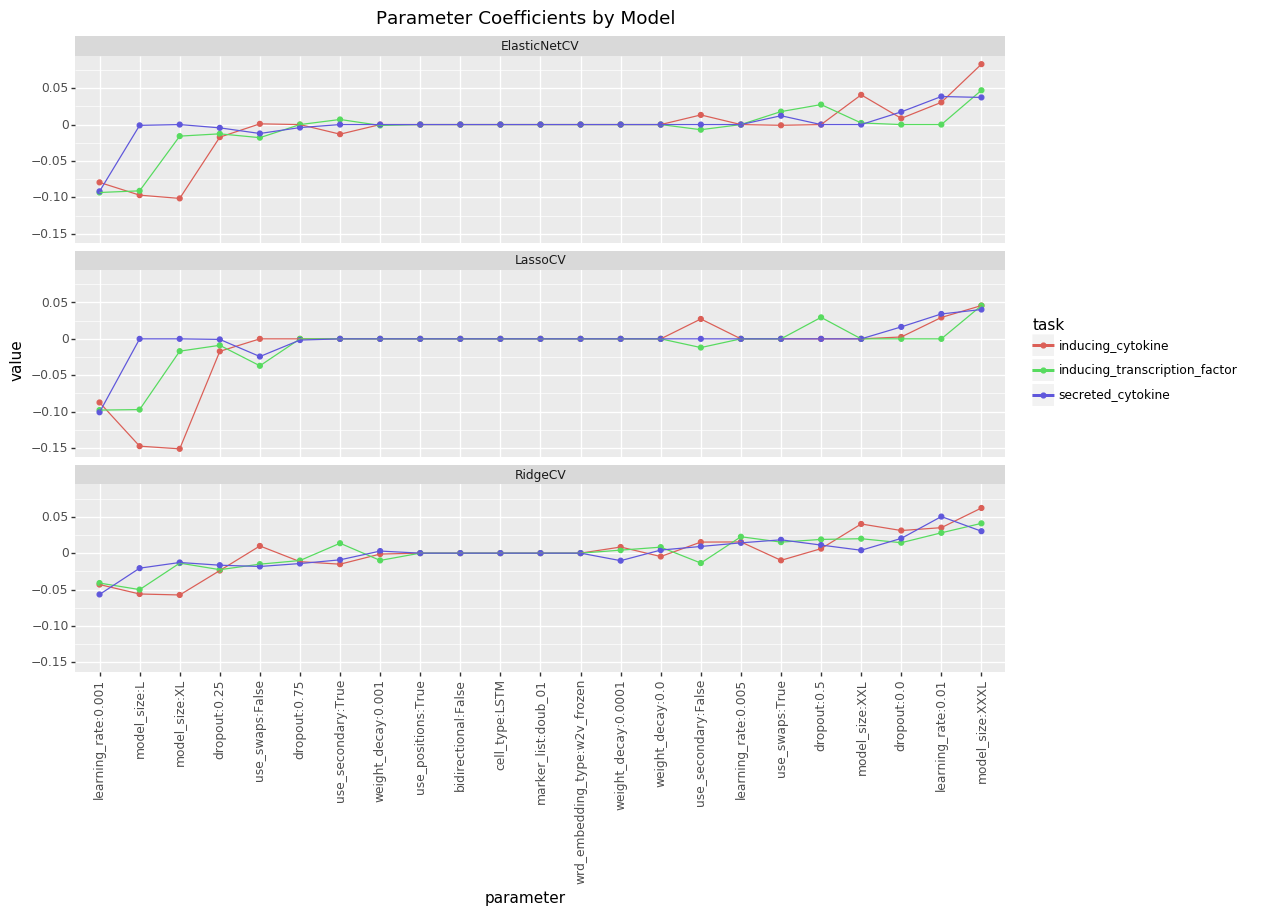

<ggplot: (-9223363302176086205)>

In [38]:
(
    pn.ggplot(
        df_coef_lng.assign(parameter=lambda df: pd.Categorical(
            df['parameter'], ordered=True, 
            categories=df.groupby('parameter')['weighted_value'].mean().sort_values().index
        )), 
        pn.aes(x='parameter', y='value', fill='task', color='task', group='task')
    ) + 
    pn.geom_point() +
    pn.geom_line() + 
    pn.ggtitle('Parameter Coefficients by Model') + 
    pn.facet_wrap('~ est', ncol=1) +
    pn.theme(figure_size=(12, 8), axis_text_x=pn.element_text(rotation=90, hjust=.5))
)

### Score Distributions

In [39]:
df_score = pd.concat([v[1].assign(task=k) for k, v in results.items()])
df_score.head()

,iteration,type,metric,value,task
0,0,test,accuracy,0.730000,inducing_cytokine
1,0,test,ct,100.000000,inducing_cytokine
2,0,test,f1,0.181818,inducing_cytokine
3,0,test,loss,0.780969,inducing_cytokine
4,0,test,lr,0.005000,inducing_cytokine


In [41]:
# Label balance
df_lbl = df_cand.assign(label=lambda df: np.where(df['label'] > 0, 1, 0))
pd.concat([
    df_lbl.assign(agg='count').groupby(['type', 'split', 'agg'])['label'].value_counts().unstack([-2, -1]),
    df_lbl.assign(agg='percent').groupby(['type', 'split', 'agg'])['label'].value_counts(normalize=True).unstack([-2, -1]).round(2)
], axis=1)

agg                                 count      percent      
label                                   0    1       0     1
type                          split                         
inducing_cytokine             test     86   14    0.86  0.14
                              train   540  133    0.80  0.20
                              val      84   13    0.87  0.13
inducing_transcription_factor test     82   18    0.82  0.18
                              train   324   86    0.79  0.21
                              val      95   22    0.81  0.19
secreted_cytokine             test     80   20    0.80  0.20
                              train   592   81    0.88  0.12
                              val      79   19    0.81  0.19

In [42]:
# Scores at best validation F1 iteration
df_bal = df_lbl.assign(metric='balance').groupby(['type', 'metric', 'split'])['label'].value_counts(normalize=True).unstack().round(2)[1].unstack([-2, -1])
(
    df_score
    .pivot_table(index=['task', 'iteration'], columns=['metric', 'type'], values='value')
    .pipe(lambda df: df.groupby('task').apply(lambda g: g.iloc[np.argmax(g[('f1', 'validation')].values)])[['ct', 'f1', 'accuracy', 'precision', 'recall']])
    .round(2)
    .pipe(lambda df: pd.concat([df, df_bal], axis=1))
    .style.background_gradient(low=.1, high=.3)
)

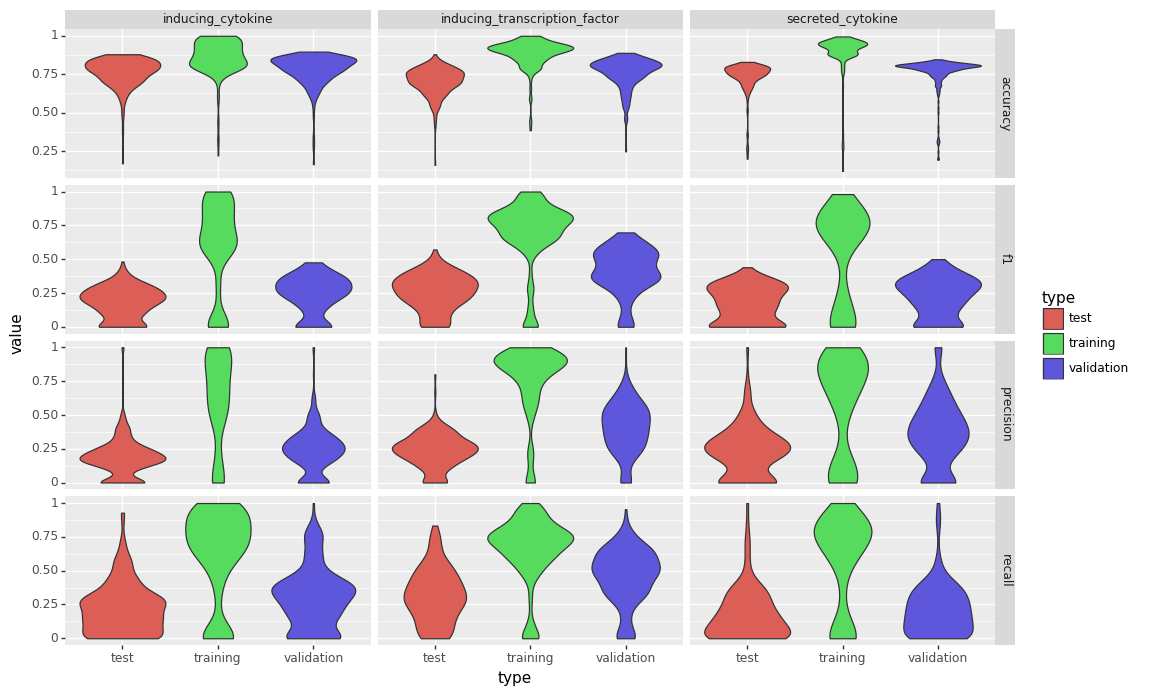

<ggplot: (8778464380964)>

In [60]:
(
    pn.ggplot(
        df_score.pipe(lambda df: df[df['metric'].isin(['f1', 'accuracy', 'precision', 'recall'])]),
        pn.aes(x='type', y='value', fill='type')
    ) + 
    pn.geom_violin() + 
    pn.facet_grid('metric ~ task', scales='free') + 
    pn.theme(figure_size=(12, 8))
)

## Export

Export top model configurations. This is based on the average performance of each parameter as determined by regression.  

Individual max scores are not used to select the top models because the validation set is so small and the search space large enough by comparison that parameter settings that result in poor models on average often end up at the top of the list.

In [61]:
top_config = {}
for k, v in df_coef_lng.groupby('parameter')['weighted_value'].mean().sort_values(ascending=False).items():
    param, val = k.split(':')
    if param not in top_config:
        top_config[param] = val
top_config

{'dropout': '0.5',
 'wrd_embedding_type': 'w2v_trained',
 'use_positions': 'True',
 'use_secondary': 'False',
 'learning_rate': '0.01',
 'cell_type': 'LSTM',
 'model_size': 'XL',
 'use_swaps': 'False',
 'bidirectional': 'True',
 'marker_list': 'mult_01',
 'weight_decay': '0.005'}

In [63]:
# Unless there is a compelling reason to do otherwise, make sure bidirectional 
# option is false to speed up training
top_config['bidirectional'] = False
top_config

{'dropout': '0.5',
 'wrd_embedding_type': 'w2v_trained',
 'use_positions': 'True',
 'use_secondary': 'False',
 'learning_rate': '0.01',
 'cell_type': 'LSTM',
 'model_size': 'XL',
 'use_swaps': 'False',
 'bidirectional': False,
 'marker_list': 'mult_01',
 'weight_decay': '0.005'}

In [64]:
# Use frozen and trainable versions of best config for further training
top_models = pd.DataFrame([
    {**dict(top_config), **dict(wrd_embedding_type=v)}
    for v in ['w2v_frozen', 'w2v_trained']
])
top_models

,bidirectional,cell_type,dropout,learning_rate,marker_list,model_size,use_positions,use_secondary,use_swaps,weight_decay,wrd_embedding_type
0,False,LSTM,0.5,0.01,mult_01,XL,True,False,False,0.005,w2v_frozen
1,False,LSTM,0.5,0.01,mult_01,XL,True,False,False,0.005,w2v_trained


In [65]:
path = osp.join(output_dir, 'top_model_configurations.json')
top_models.to_json(path)
path

'/lab/data/results/gridsearch-dev/run1/top_model_configurations.json'